### Data Analysis for NCVS Paper on Victimization | Midterm Project for DATA118

In [3]:
# Notebook prereqs
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('ignore', FutureWarning)

#### 0: Prepping Dataset (Mainly assigning Categorical Variables)
IMPORT NOTE: "PRINCIPAL" refers to whoever is filling out the report on behalf of the household, "REFERENCE" refers to the head of the household

In [4]:
proj_df=pd.read_csv('NCVS_2020.csv')
MAPPINGS = {}

# takes in a codebook string and returns a new df with replaced vars and the mappings
def modify_df(df: pd.DataFrame, 
              category: str, 
              levels: str = None, 
              to_drop: tuple = (98, 99)) -> pd.DataFrame:
    for value in to_drop:
        df = df.drop(df[df[category] == value].index)
    if not levels:
        df[category + "_VIZ"] = df[category]
        return df, {}
    levels = {int(row[:2]): row[2:].strip() for row in levels.split("\n")}
    df[category + "_VIZ"] = df.replace({category: levels})[category]
    return df, levels

# Education
ed_levels = """00 None
01 None
02 None
03 None
04 None
05 None
06 None
07 None
08 None
09 None
10 None
11 None
12 None
21 High School 
22 High School
23 High School
24 High School
25 High School
26 High School
27 None
28 High School
40 High School
41 Associate's
42 Bachelor's
43 Master's
44 Prof. School / PhD
45 Prof. School / PhD"""
proj_df, MAPPINGS["ED"] = modify_df(proj_df, "ED", ed_levels)

# Income
inc_levels = """01 Less than $5,000
02 $5,000 to $7,499
03 $7,500 to $9,999
04 $10,000 to $12,499
05 $12,500 to $14,999
06 $15,000 to $17,499
07 $17,500 to $19,999
08 $20,000 to $24,999
09 $25,000 to $29,999
10 $30,000 to $34,999
11 $35,000 to $39,999
12 $40,000 to $49,999
13 $50,000 to $74,999
15 $75,000 to $99,999
16 $100,000-$149,999
17 $150,000-$199,999
18 $200,000+""".replace(" to ", "-")
proj_df, MAPPINGS["INCOME"] = modify_df(proj_df, "INCOME", inc_levels)

# Number of Incidents
proj_df, MAPPINGS["NUM_INCIDENTS"] = modify_df(proj_df, "NUM_INCIDENTS")

# Restricted Living
res_levels = """1 Restricted
2 Unrestricted"""
proj_df, MAPPINGS["RESTRICTED"] = modify_df(proj_df, "RESTRICTED", res_levels, (8, 9, -1))

# Stolen Property
stolen_levels = """1 Yes
2 No"""
proj_df, MAPPINGS["STOLEN"] = modify_df(proj_df, "STOLEN", stolen_levels, (8, 9, 3))

# BROKEN_IN
broken_levels = """1 Yes
2 No"""
proj_df, MAPPINGS["BROKEN_IN"] = modify_df(proj_df, "BROKEN_IN", stolen_levels, (8, 9, 3))

# Count func
def add_ordering_column(df: pd.DataFrame, category: str) -> pd.DataFrame:
    new_dict = {v: k for k, v in MAPPINGS[category].items()}
    df[category] = df.replace({category + "_VIZ": new_dict})[category + "_VIZ"]
    return df

proj_df[["INCOME_VIZ", "ED_VIZ", "NUM_INCIDENTS_VIZ", "RESTRICTED_VIZ", "STOLEN_VIZ"]]

,INCOME_VIZ,ED_VIZ,NUM_INCIDENTS_VIZ,RESTRICTED_VIZ,STOLEN_VIZ
0,"$100,000-$149,999",Bachelor's,1,Unrestricted,No
1,"$5,000-$7,499",Associate's,2,Unrestricted,Yes
2,"$5,000-$7,499",Associate's,2,Unrestricted,Yes
3,"$25,000-$29,999",Bachelor's,1,Unrestricted,No
4,"$100,000-$149,999",High School,1,Unrestricted,Yes
...,...,...,...,...,...
8038,"$7,500-$9,999",None,3,Unrestricted,No
8039,"$40,000-$49,999",High School,2,Unrestricted,Yes
8040,"$40,000-$49,999",High School,2,Unrestricted,Yes
8041,"$200,000+",Prof. School / PhD,1,Unrestricted,Yes


In [54]:
proj_df.shape

(7995, 87)

#### 2: Characterizing the Sample via Distribution Analysis

Num Reports vs Num Incidents?

array([ 1,  2,  7,  3,  4,  5,  6,  8, 12, 11, 10], dtype=int64)

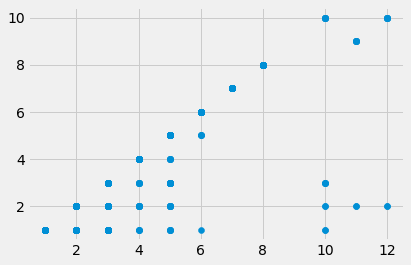

In [43]:
plt.scatter(proj_df.NUM_REPORT, proj_df.NUM_INCIDENTS)
proj_df.NUM_REPORT.unique()

    NUM_REPORT  Counts
0            1    5182
1            2    1572
2            3     601
3            4     266
4            5     200
5            6      72
6            7      35
7            8      24
8           10      20
9           12      12
10          11      11


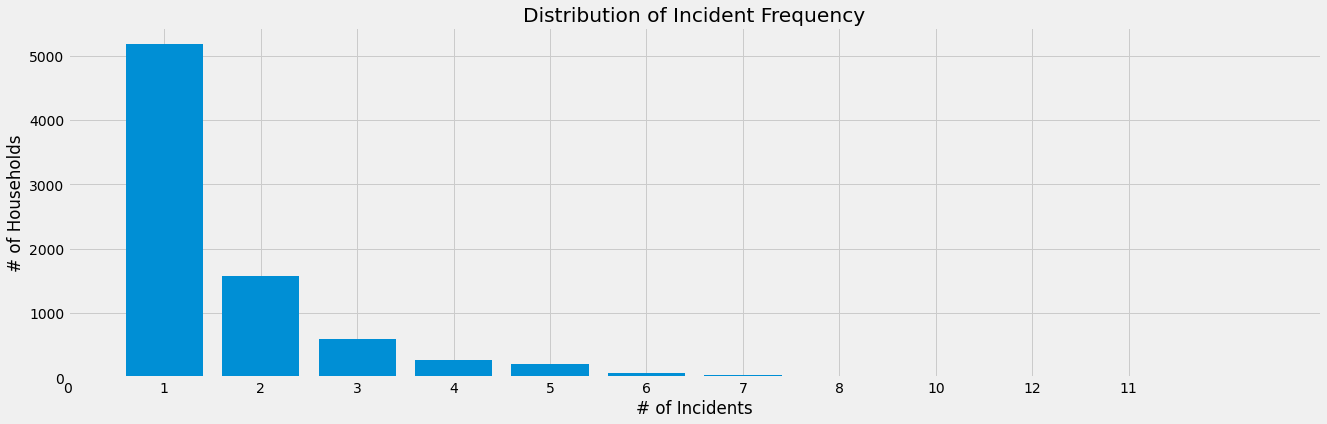

In [45]:
incident_counts = proj_df["NUM_REPORT"].value_counts().reset_index()
incident_counts.columns = ["NUM_REPORT", "Counts"]
print(incident_counts)
plt.figure(figsize=(20, 6))
plt.bar(incident_counts.NUM_REPORT, incident_counts.Counts)
plt.xticks(range(incident_counts.NUM_REPORT.size + 1), [0] + list(incident_counts.NUM_REPORT))
plt.ylabel("# of Households")
plt.xlabel("# of Incidents")
plt.title("Distribution of Incident Frequency")
plt.show()

2.1 Education Level

In [5]:
ed_counts = proj_df["ED_VIZ"].value_counts().reset_index()
ed_counts.columns = ["ED_VIZ", "Counts"]
ed_counts["Percentages"] = (ed_counts["Counts"] / ed_counts.Counts.sum() * 100).round(decimals=2)
ed_counts

,ED_VIZ,Counts,Percentages
0,High School,3358,42.00
1,Bachelor's,1747,21.85
2,None,1005,12.57
3,Master's,802,10.03
4,Associate's,797,9.97
5,Prof. School / PhD,286,3.58


2.2 Income

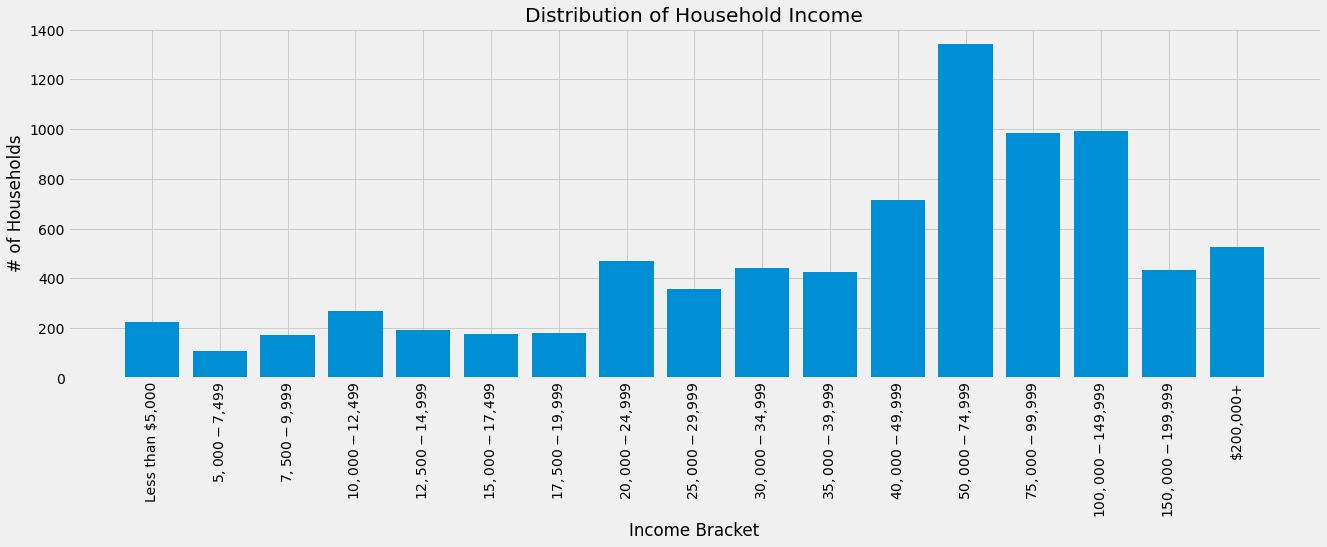

In [6]:
inc_counts = proj_df["INCOME_VIZ"].value_counts().reset_index()
inc_counts.columns = ["INCOME_VIZ", "Counts"]
inc_counts = add_ordering_column(inc_counts, "INCOME").sort_values("INCOME")
plt.figure(figsize=(20, 6))
plt.bar(inc_counts.INCOME_VIZ, inc_counts.Counts)
plt.xticks(range(inc_counts.INCOME_VIZ.size), inc_counts.INCOME_VIZ, rotation='vertical')
plt.ylabel("# of Households")
plt.xlabel("Income Bracket")
plt.title("Distribution of Household Income")
plt.show()

2.3 Incident Frequency

   NUM_INCIDENTS_VIZ  Counts  NUM_INCIDENTS
0                  1    5424              1
1                  2    1466              2
2                  3     543              3
3                  4     248              4
4                  5     160              5
5                  6      66              6
6                  7      35              7
7                  8      24              8
9                  9       9              9
8                 10      20             10


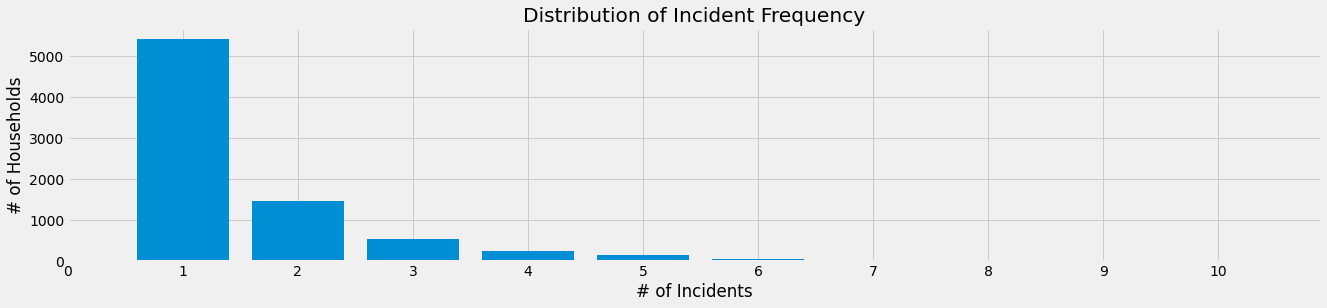

In [56]:
incident_counts = proj_df["NUM_INCIDENTS_VIZ"].value_counts().reset_index()
incident_counts.columns = ["NUM_INCIDENTS_VIZ", "Counts"]
incident_counts = add_ordering_column(incident_counts, "NUM_INCIDENTS").sort_values("NUM_INCIDENTS")
print(incident_counts)
plt.figure(figsize=(20, 4))
plt.bar(incident_counts.NUM_INCIDENTS_VIZ, incident_counts.Counts)
plt.xticks(range(incident_counts.NUM_INCIDENTS_VIZ.size + 1), [0] + list(incident_counts.NUM_INCIDENTS_VIZ))
plt.ylabel("# of Households")
plt.xlabel("# of Incidents")
plt.title("Distribution of Incident Frequency")
plt.show()

#### 3: Variable Relationships

3.1 Annual Income by Education

<AxesSubplot:title={'center':'Income Bracket by Level of Education (Normalized)'}, xlabel='Income Bracket', ylabel='Proportion of Households'>

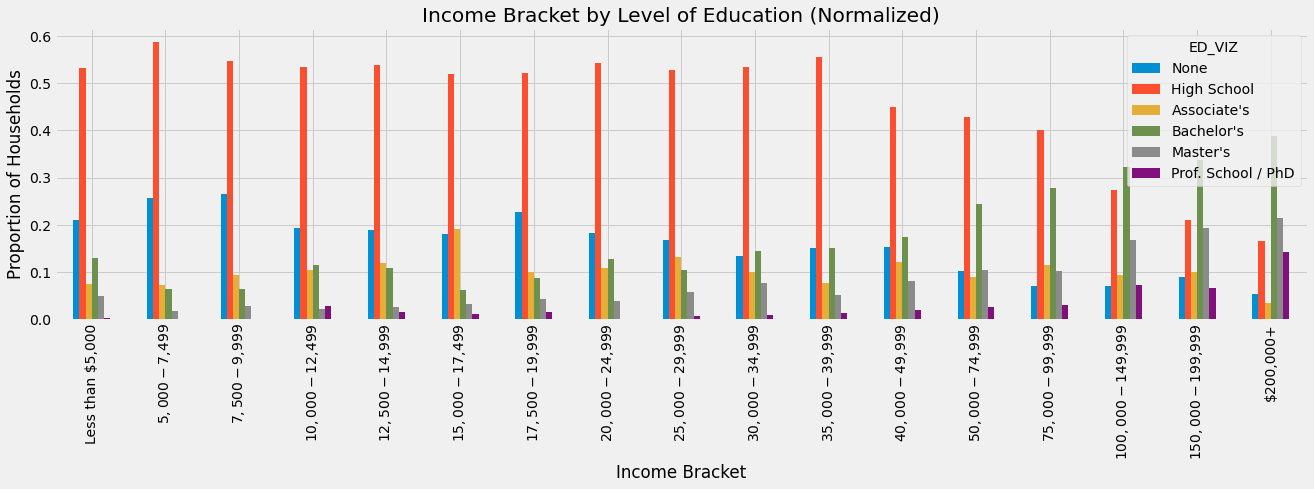

In [60]:
df = pd.crosstab(proj_df['INCOME_VIZ'], proj_df['ED_VIZ'], normalize='index')
df = df[["None", "High School", "Associate's", "Bachelor's", "Master's", "Prof. School / PhD"]]
mappings = {v: k for k, v in MAPPINGS["INCOME"].items()}
df: pd.DataFrame = df.iloc[df.index.map(mappings).argsort()]
df.plot(kind="bar", figsize=(20, 5), xlabel="Income Bracket", ylabel="Proportion of Households", title="Income Bracket by Level of Education (Normalized)")

3.2-a Restricted Living

<BarContainer object of 2 artists>

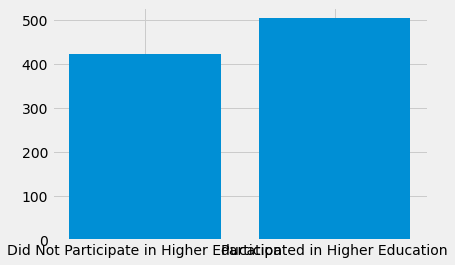

In [55]:
df = pd.crosstab(proj_df['RESTRICTED_VIZ'], proj_df['ED_VIZ'])
df = df[["None", "High School", "Associate's", "Bachelor's", "Master's", "Prof. School / PhD"]]
mappings = {v: k for k, v in MAPPINGS["ED"].items()}
df: pd.DataFrame = df.iloc[df.index.map(mappings).argsort()]

restricted_data = {
    "Did Not Participate in Higher Education": df.iloc[0]["High School"] + df.iloc[0]["None"],
    "Participated in Higher Education": df.iloc[0].sum() - df.iloc[0]["High School"] - df.iloc[0]["None"]
}

plt.bar(restricted_data.keys(), restricted_data.values())

3.2-b Stolen Property

<AxesSubplot:title={'center':'Income Bracket by Level of Education'}, xlabel='Income Bracket', ylabel='Proportion of Households'>

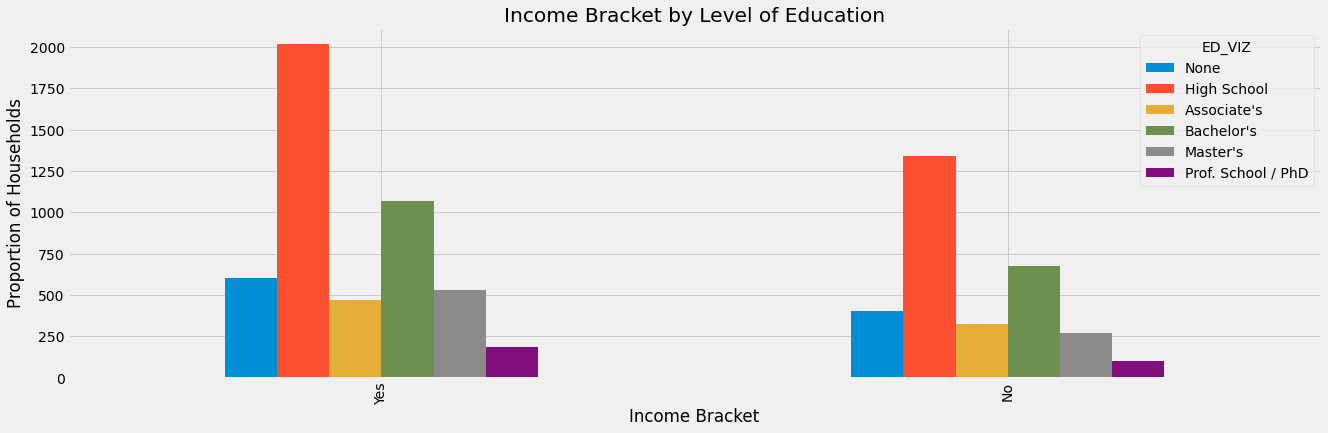

In [10]:
df = pd.crosstab(proj_df['STOLEN_VIZ'], proj_df['ED_VIZ'])
df = df[["None", "High School", "Associate's", "Bachelor's", "Master's", "Prof. School / PhD"]]
mappings = {v: k for k, v in MAPPINGS["STOLEN"].items()}
df: pd.DataFrame = df.iloc[df.index.map(mappings).argsort()]
df.plot(kind="bar", figsize=(20, 6), xlabel="Stolen", ylabel="Proportion of Households", title="Stolen Property by Proportion of Households")

Broken In vs Education

<AxesSubplot:title={'center':'Households Suffering a Break-In by Education Level (Normalized)'}, xlabel='Education Level', ylabel='Proportion of Households'>

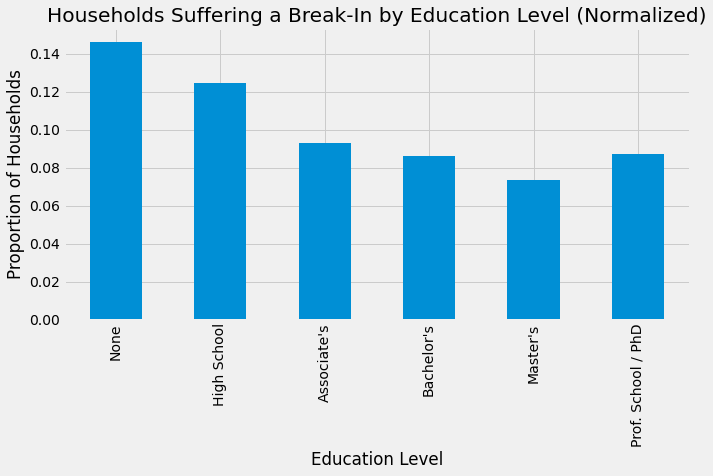

In [27]:
df = pd.crosstab(proj_df['ED_VIZ'], proj_df['BROKEN_IN_VIZ'], normalize="index")
mappings = {v: k for k, v in MAPPINGS["ED"].items()}
df: pd.DataFrame = df.iloc[df.index.map(mappings).argsort()]
df["Yes"].plot(kind="bar", figsize=(10, 5), xlabel="Education Level", ylabel="Proportion of Households", title="Households Suffering a Break-In by Education Level (Normalized)")

Broken In vs Income

<AxesSubplot:title={'center':'Households Suffering a Break-In by Income Bracket (Normalized)'}, xlabel='Income Bracket', ylabel='Proportion of Households'>

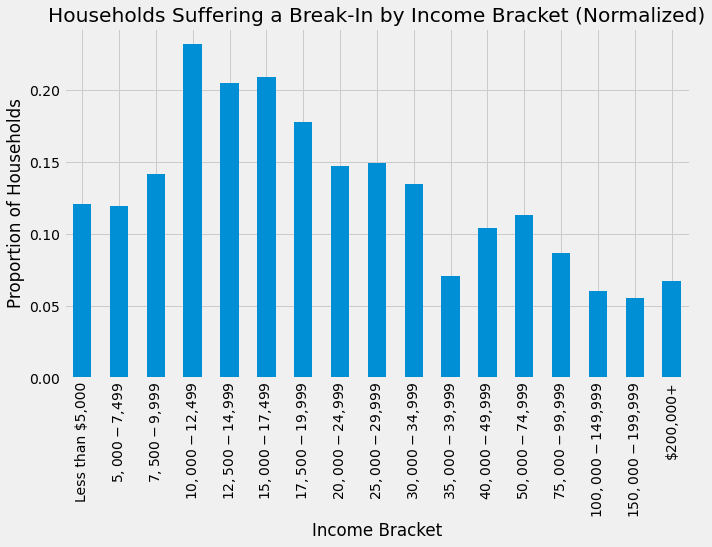

In [33]:
df = pd.crosstab(proj_df['INCOME_VIZ'], proj_df['BROKEN_IN_VIZ'], normalize="index")
mappings = {v: k for k, v in MAPPINGS["INCOME"].items()}
df: pd.DataFrame = df.iloc[df.index.map(mappings).argsort()]
df["Yes"].plot(kind="bar", figsize=(10, 6), xlabel="Income Bracket", ylabel="Proportion of Households", title="Households Suffering a Break-In by Income Bracket (Normalized)")

3.3 Incident Frequency

<AxesSubplot:title={'center':'Incident Frequency for Various Levels of Education (Normalized)'}, xlabel='# of Incidents', ylabel='Proportion of Households'>

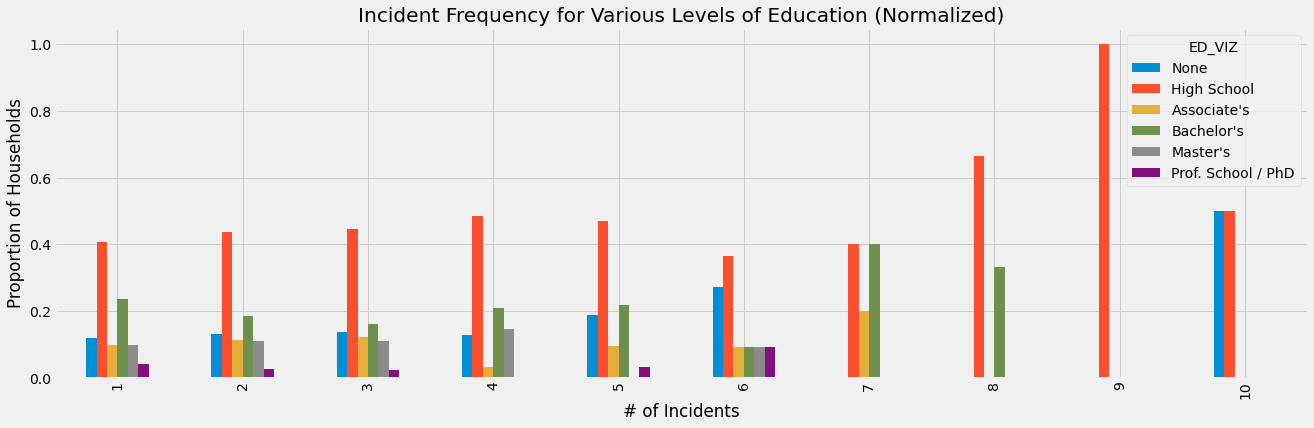

In [46]:
df = pd.crosstab(proj_df['NUM_INCIDENTS'], proj_df['ED_VIZ'], normalize="index")
df = df[["None", "High School", "Associate's", "Bachelor's", "Master's", "Prof. School / PhD"]]
mappings = {v: k for k, v in MAPPINGS["NUM_INCIDENTS"].items()}
df: pd.DataFrame = df.iloc[df.index.map(mappings).argsort()]
df.plot(kind="bar", figsize=(20, 6), xlabel="# of Incidents", ylabel="Proportion of Households", title="Incident Frequency for Various Levels of Education (Normalized)")

Incident Frequency by Income

<AxesSubplot:title={'center':'Income Bracket by Level of Education'}, xlabel='Income Bracket', ylabel='Proportion of Households'>

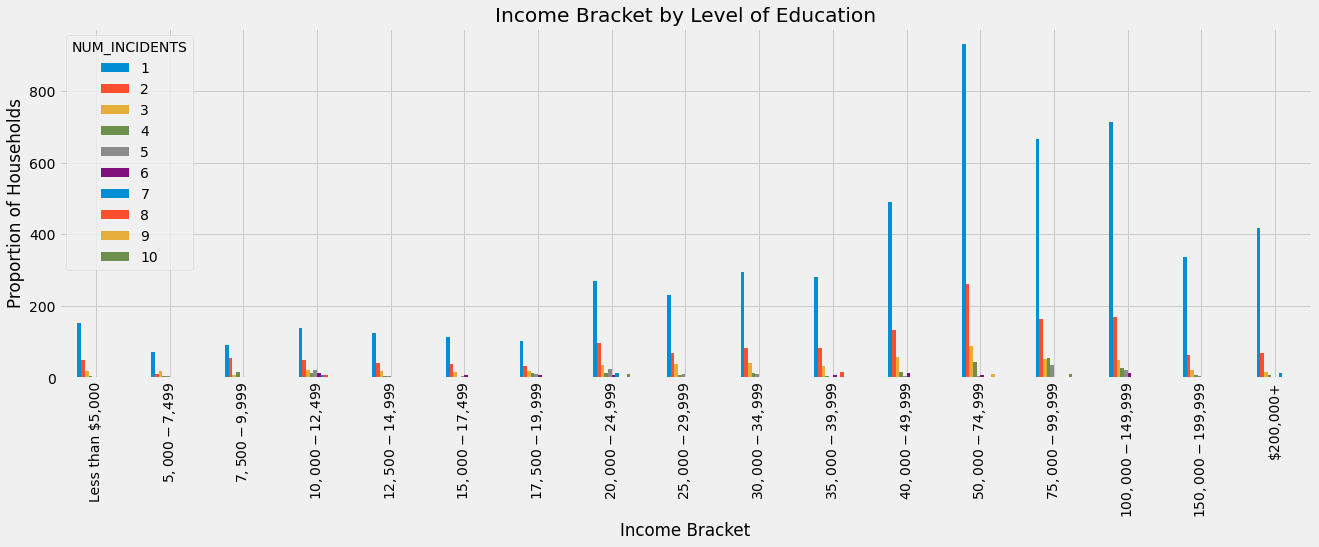

In [13]:
df = pd.crosstab(proj_df['INCOME_VIZ'], proj_df['NUM_INCIDENTS'])
mappings = {v: k for k, v in MAPPINGS["INCOME"].items()}
df: pd.DataFrame = df.iloc[df.index.map(mappings).argsort()]
df.plot(kind="bar", figsize=(20, 6), xlabel="Income Bracket", ylabel="Proportion of Households", title="Hmm")